In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# Dataset path
data_dir = "dataset"  # Set your dataset root path

# Image size
img_size = 224

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(img_size, scale=(0.9,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load datasets
train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), transform=train_transforms)
val_ds   = datasets.ImageFolder(os.path.join(data_dir,"validation"), transform=val_transforms)
test_ds  = datasets.ImageFolder(os.path.join(data_dir,"test"), transform=val_transforms)

# DataLoaders
train_ld = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_ld   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_ld  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# Check
print("Classes:", train_ds.classes)
print("Train:", len(train_ds), "Validation:", len(val_ds), "Test:", len(test_ds))

Classes: ['diabetes', 'nondiabetes']
Train: 2500 Validation: 600 Test: 50


In [3]:
# Load pretrained MobileNetV3-Small
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# Replace classifier for 2 classes
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model = model.to(device)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

In [5]:
def run_epoch(loader, train=True):
    model.train(train)
    losses, preds_all, labels_all = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            out = model(x)
            loss = criterion(out, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
        preds_all.append(out.detach().softmax(1)[:,1].cpu().numpy())
        labels_all.append(y.cpu().numpy())
    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)
    auc = roc_auc_score(labels_all, preds_all)
    acc = accuracy_score(labels_all, (preds_all>=0.5).astype(int))
    return np.mean(losses), acc, auc, labels_all, preds_all

In [6]:
best_auc = 0.0
num_epochs = 25
best_model_path = "best_mnv3_small.pth"

train_losses, val_losses = [], []
train_aucs, val_aucs = [], []

for epoch in range(num_epochs):
    tr_loss, tr_acc, tr_auc, _, _ = run_epoch(train_ld, train=True)
    va_loss, va_acc, va_auc, _, _ = run_epoch(val_ld, train=False)
    
    scheduler.step()
    
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_aucs.append(tr_auc)
    val_aucs.append(va_auc)
    
    print(f"Epoch {epoch+1:02d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} AUC: {tr_auc:.3f} | "
          f"Val Loss: {va_loss:.4f} Acc: {va_acc:.3f} AUC: {va_auc:.3f}")
    
    if va_auc > best_auc:
        best_auc = va_auc
        torch.save(model.state_dict(), best_model_path)

print("Best model saved at:", best_model_path)

Epoch 01 | Train Loss: 0.2867 Acc: 0.886 AUC: 0.952 | Val Loss: 0.4118 Acc: 0.778 AUC: 0.976
Epoch 02 | Train Loss: 0.0735 Acc: 0.973 AUC: 0.997 | Val Loss: 0.1836 Acc: 0.912 AUC: 0.996
Epoch 02 | Train Loss: 0.0735 Acc: 0.973 AUC: 0.997 | Val Loss: 0.1836 Acc: 0.912 AUC: 0.996
Epoch 03 | Train Loss: 0.0573 Acc: 0.987 AUC: 0.999 | Val Loss: 0.0802 Acc: 0.968 AUC: 0.996
Epoch 03 | Train Loss: 0.0573 Acc: 0.987 AUC: 0.999 | Val Loss: 0.0802 Acc: 0.968 AUC: 0.996
Epoch 04 | Train Loss: 0.0394 Acc: 0.985 AUC: 0.999 | Val Loss: 0.0917 Acc: 0.972 AUC: 0.996
Epoch 04 | Train Loss: 0.0394 Acc: 0.985 AUC: 0.999 | Val Loss: 0.0917 Acc: 0.972 AUC: 0.996
Epoch 05 | Train Loss: 0.0372 Acc: 0.991 AUC: 1.000 | Val Loss: 0.0661 Acc: 0.977 AUC: 0.997
Epoch 05 | Train Loss: 0.0372 Acc: 0.991 AUC: 1.000 | Val Loss: 0.0661 Acc: 0.977 AUC: 0.997
Epoch 06 | Train Loss: 0.0940 Acc: 0.984 AUC: 0.998 | Val Loss: 0.0853 Acc: 0.953 AUC: 0.999
Epoch 06 | Train Loss: 0.0940 Acc: 0.984 AUC: 0.998 | Val Loss: 0.0853

In [21]:
# Save training data to CSV for custom graph creation
import pandas as pd

# Create DataFrame with training history
training_data = {
    'epoch': list(range(1, num_epochs + 1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_auc': train_aucs,
    'val_auc': val_aucs
}

df = pd.DataFrame(training_data)

# Save to CSV
csv_filename = 'mobilenetv3_training_history.csv'
df.to_csv(csv_filename, index=False)
print(f"Training data saved to: {csv_filename}")

# Display first few rows
print("\nTraining History Data:")
print(df.head())
print(f"\nTotal epochs: {len(df)}")
print(f"Best validation AUC: {max(val_aucs):.4f} at epoch {val_aucs.index(max(val_aucs)) + 1}")

Training data saved to: mobilenetv3_training_history.csv

Training History Data:
   epoch  train_loss  val_loss  train_auc   val_auc
0      1    0.286664  0.411834   0.952214  0.975911
1      2    0.073481  0.183626   0.996699  0.996356
2      3    0.057297  0.080162   0.998826  0.996189
3      4    0.039351  0.091729   0.999224  0.995978
4      5    0.037191  0.066059   0.999580  0.996889

Total epochs: 25
Best validation AUC: 0.9997 at epoch 11


In [7]:
# TEST DATASET EVALUATION
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transforms (same as your original test transforms)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Test dataset
test_ds = datasets.ImageFolder("SelfCollectedTest", transform=val_transforms)
test_ld = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Load best model
model.load_state_dict(torch.load('best_mnv3_small.pth', map_location=device, weights_only=True))
model.eval()

probs, labels = [], []

with torch.no_grad():
    for x, y in test_ld:
        x = x.to(device)
        out = model(x).softmax(1)[:, 1].cpu().numpy()
        probs.append(out)
        labels.append(y.numpy())

probs = np.concatenate(probs)
labels = np.concatenate(labels)
preds = (probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(labels, preds)
auc = roc_auc_score(labels, probs)
report = classification_report(labels, preds, target_names=test_ds.classes, digits=3)
cm = confusion_matrix(labels, preds)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

print("Test Accuracy:", acc)
print("Test AUC:", auc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(report)

Test Accuracy: 0.9752475247524752
Test AUC: 0.9970713655523968
Sensitivity: 0.9900990099009901
Specificity: 0.9603960396039604
              precision    recall  f1-score   support

    diabetes      0.990     0.960     0.975       404
 nondiabetes      0.962     0.990     0.976       404

    accuracy                          0.975       808
   macro avg      0.976     0.975     0.975       808
weighted avg      0.976     0.975     0.975       808



Confusion matrix saved as: confusion_matrix_test_mobilenetv3.png


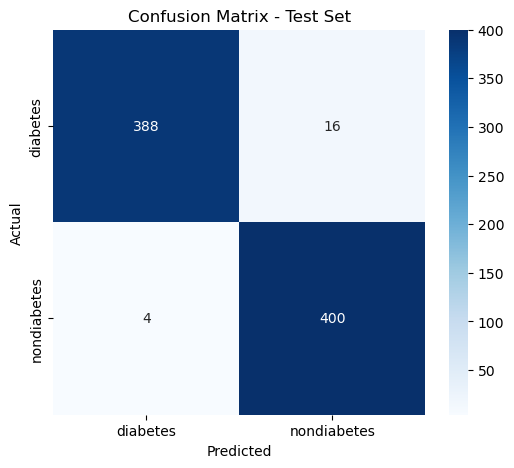

In [8]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")

# Save the confusion matrix
plt.savefig('confusion_matrix_test_mobilenetv3.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as: confusion_matrix_test_mobilenetv3.png")

plt.show()

Training plots saved as: mobilenetv3_training_plots.png


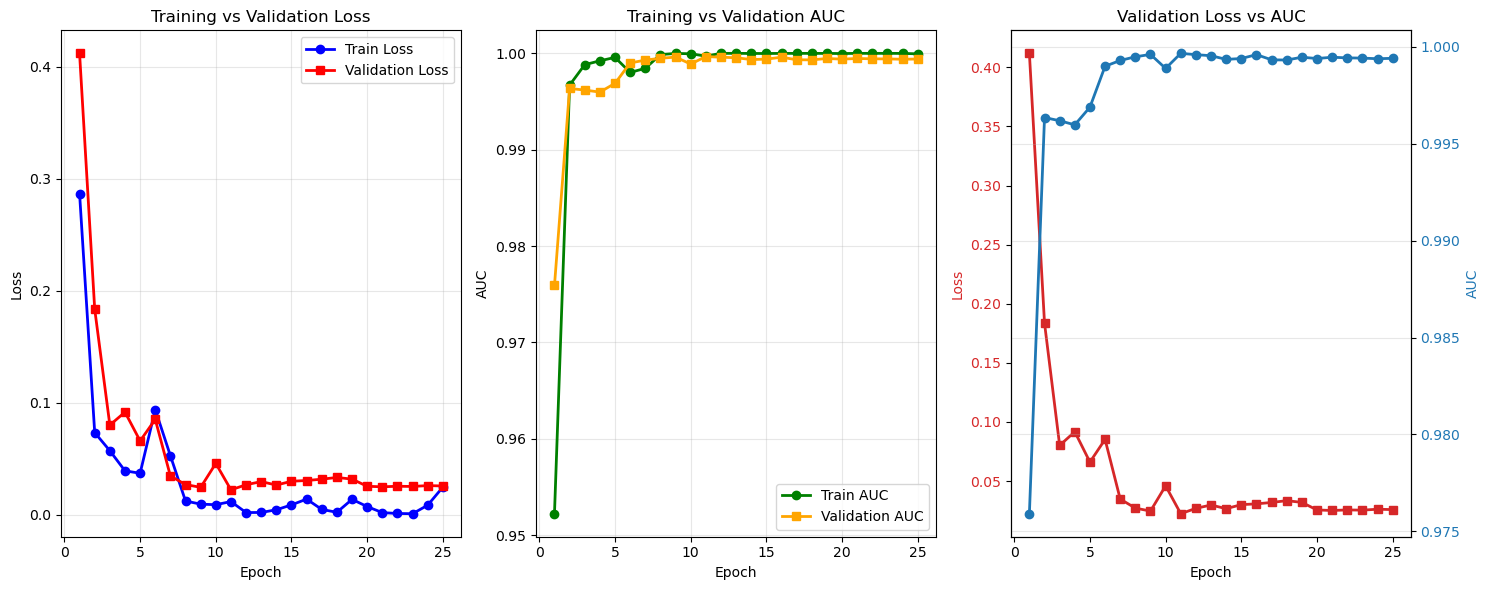

In [16]:
# Plot Training vs Validation Loss and AUC
plt.figure(figsize=(15,6))

# Plot 1: Training vs Validation Loss
plt.subplot(1,3,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o', color='blue', linewidth=2)
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='s', color='red', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Training vs Validation AUC
plt.subplot(1,3,2)
plt.plot(range(1, len(train_aucs)+1), train_aucs, label='Train AUC', marker='o', color='green', linewidth=2)
plt.plot(range(1, len(val_aucs)+1), val_aucs, label='Validation AUC', marker='s', color='orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Combined Loss and AUC (dual y-axis)
plt.subplot(1,3,3)
ax1 = plt.gca()
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(val_losses)+1), val_losses, color=color, marker='s', linewidth=2, label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('AUC', color=color)
ax2.plot(range(1, len(val_aucs)+1), val_aucs, color=color, marker='o', linewidth=2, label='Val AUC')
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Validation Loss vs AUC")
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save the training plots
plt.savefig('mobilenetv3_training_plots.png', dpi=300, bbox_inches='tight')
print("Training plots saved as: mobilenetv3_training_plots.png")

plt.show()


Loaded training data from CSV:
   epoch  train_loss  val_loss  train_auc   val_auc
0      1    0.286664  0.411834   0.952214  0.975911
1      2    0.073481  0.183626   0.996699  0.996356
2      3    0.057297  0.080162   0.998826  0.996189
3      4    0.039351  0.091729   0.999224  0.995978
4      5    0.037191  0.066059   0.999580  0.996889
Custom analysis plots saved as: mobilenetv3_custom_analysis.png
Custom analysis plots saved as: mobilenetv3_custom_analysis.png


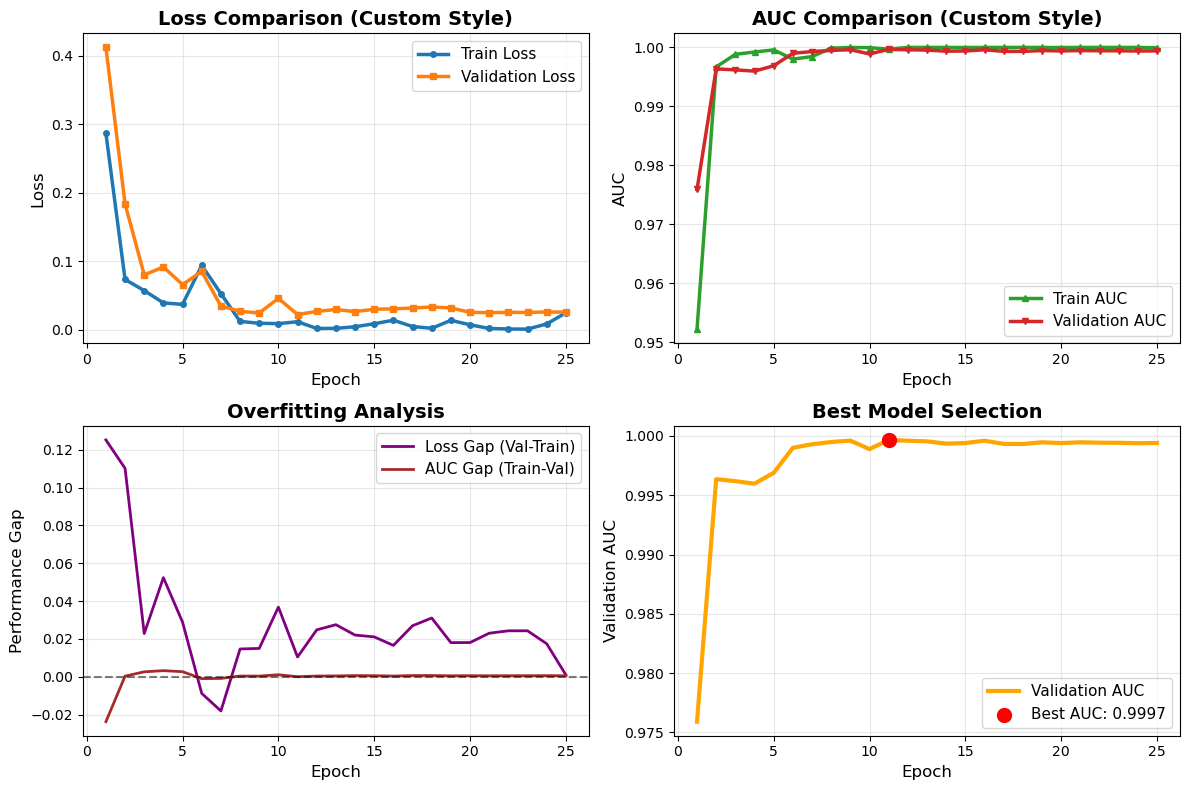


📊 TRAINING SUMMARY STATISTICS:
Metric               Min        Max        Final      Best Epoch  
-----------------------------------------------------------------
Train Loss           0.0011     0.2867     0.0249     23          
Val Loss             0.0224     0.4118     0.0259     11          
Train AUC            0.9522     1.0000     1.0000     12          
Val AUC              0.9759     0.9997     0.9994     11          


In [22]:
# Example: How to recreate graphs from saved CSV
# This cell shows how you can load and plot the data later for custom analysis

# Load the saved training data
df_loaded = pd.read_csv('mobilenetv3_training_history.csv')
print("Loaded training data from CSV:")
print(df_loaded.head())

# Custom graph example 1: Smooth lines with different styles
plt.figure(figsize=(12, 8))

# Subplot 1: Loss comparison with custom styling
plt.subplot(2, 2, 1)
plt.plot(df_loaded['epoch'], df_loaded['train_loss'], 
         label='Train Loss', color='#1f77b4', linewidth=2.5, marker='o', markersize=4)
plt.plot(df_loaded['epoch'], df_loaded['val_loss'], 
         label='Validation Loss', color='#ff7f0e', linewidth=2.5, marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Comparison (Custom Style)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Subplot 2: AUC comparison
plt.subplot(2, 2, 2)
plt.plot(df_loaded['epoch'], df_loaded['train_auc'], 
         label='Train AUC', color='#2ca02c', linewidth=2.5, marker='^', markersize=4)
plt.plot(df_loaded['epoch'], df_loaded['val_auc'], 
         label='Validation AUC', color='#d62728', linewidth=2.5, marker='v', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC Comparison (Custom Style)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Subplot 3: Gap analysis (Train vs Val)
plt.subplot(2, 2, 3)
loss_gap = df_loaded['val_loss'] - df_loaded['train_loss']
auc_gap = df_loaded['train_auc'] - df_loaded['val_auc']
plt.plot(df_loaded['epoch'], loss_gap, label='Loss Gap (Val-Train)', color='purple', linewidth=2)
plt.plot(df_loaded['epoch'], auc_gap, label='AUC Gap (Train-Val)', color='brown', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Performance Gap', fontsize=12)
plt.title('Overfitting Analysis', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Subplot 4: Best performance indicators
plt.subplot(2, 2, 4)
best_val_auc_epoch = df_loaded.loc[df_loaded['val_auc'].idxmax(), 'epoch']
best_val_auc_value = df_loaded['val_auc'].max()

plt.plot(df_loaded['epoch'], df_loaded['val_auc'], color='orange', linewidth=3, label='Validation AUC')
plt.scatter([best_val_auc_epoch], [best_val_auc_value], color='red', s=100, zorder=5, label=f'Best AUC: {best_val_auc_value:.4f}')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation AUC', fontsize=12)
plt.title('Best Model Selection', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save custom analysis plots
plt.savefig('mobilenetv3_custom_analysis.png', dpi=300, bbox_inches='tight')
print("Custom analysis plots saved as: mobilenetv3_custom_analysis.png")

plt.show()

# Print summary statistics
print(f"\n📊 TRAINING SUMMARY STATISTICS:")
print(f"{'Metric':<20} {'Min':<10} {'Max':<10} {'Final':<10} {'Best Epoch':<12}")
print("-" * 65)
print(f"{'Train Loss':<20} {df_loaded['train_loss'].min():<10.4f} {df_loaded['train_loss'].max():<10.4f} {df_loaded['train_loss'].iloc[-1]:<10.4f} {df_loaded['train_loss'].idxmin()+1:<12}")
print(f"{'Val Loss':<20} {df_loaded['val_loss'].min():<10.4f} {df_loaded['val_loss'].max():<10.4f} {df_loaded['val_loss'].iloc[-1]:<10.4f} {df_loaded['val_loss'].idxmin()+1:<12}")
print(f"{'Train AUC':<20} {df_loaded['train_auc'].min():<10.4f} {df_loaded['train_auc'].max():<10.4f} {df_loaded['train_auc'].iloc[-1]:<10.4f} {df_loaded['train_auc'].idxmax()+1:<12}")
print(f"{'Val AUC':<20} {df_loaded['val_auc'].min():<10.4f} {df_loaded['val_auc'].max():<10.4f} {df_loaded['val_auc'].iloc[-1]:<10.4f} {df_loaded['val_auc'].idxmax()+1:<12}")

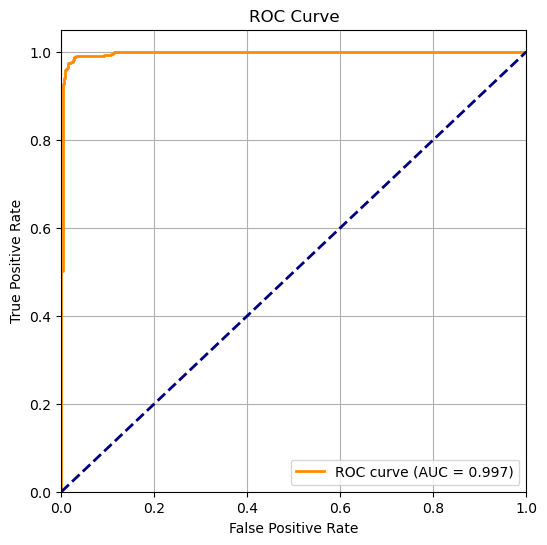

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


device: cuda
Found 50 test samples across classes: ['diabetes', 'nondiabetes']
class_to_idx: {'diabetes': 0, 'nondiabetes': 1}
Indices: [37, 32, 34, 8, 31, 27]


C:\Users\tawhi\AppData\Local\Temp\ipykernel_10284\442905259.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=dev

------------------------------------------------------------
Sample 1: idx=37 file=r_nd_(218).jpg
GT: nondiabetes (index 1)
Logits: [-6.488909   5.3912053]
Probs: {'diabetes': 6.926745300006587e-06, 'nondiabetes': 0.999993085861206}
Pred: nondiabetes (index 1)
------------------------------------------------------------
Sample 2: idx=32 file=r_nd_(153).jpg
GT: nondiabetes (index 1)
Logits: [-8.579954  7.013386]
Probs: {'diabetes': 1.6900457922019996e-07, 'nondiabetes': 0.9999998807907104}
Pred: nondiabetes (index 1)
------------------------------------------------------------
Sample 3: idx=34 file=r_nd_(2).jpg
GT: nondiabetes (index 1)
Logits: [-8.282293  6.548205]
Probs: {'diabetes': 3.624069222496473e-07, 'nondiabetes': 0.9999996423721313}
Pred: nondiabetes (index 1)
------------------------------------------------------------
Sample 4: idx=8 file=r_d_(181).jpg
GT: diabetes (index 0)
Logits: [ 5.938322 -6.776202]
Probs: {'diabetes': 0.9999970197677612, 'nondiabetes': 3.00712167700112

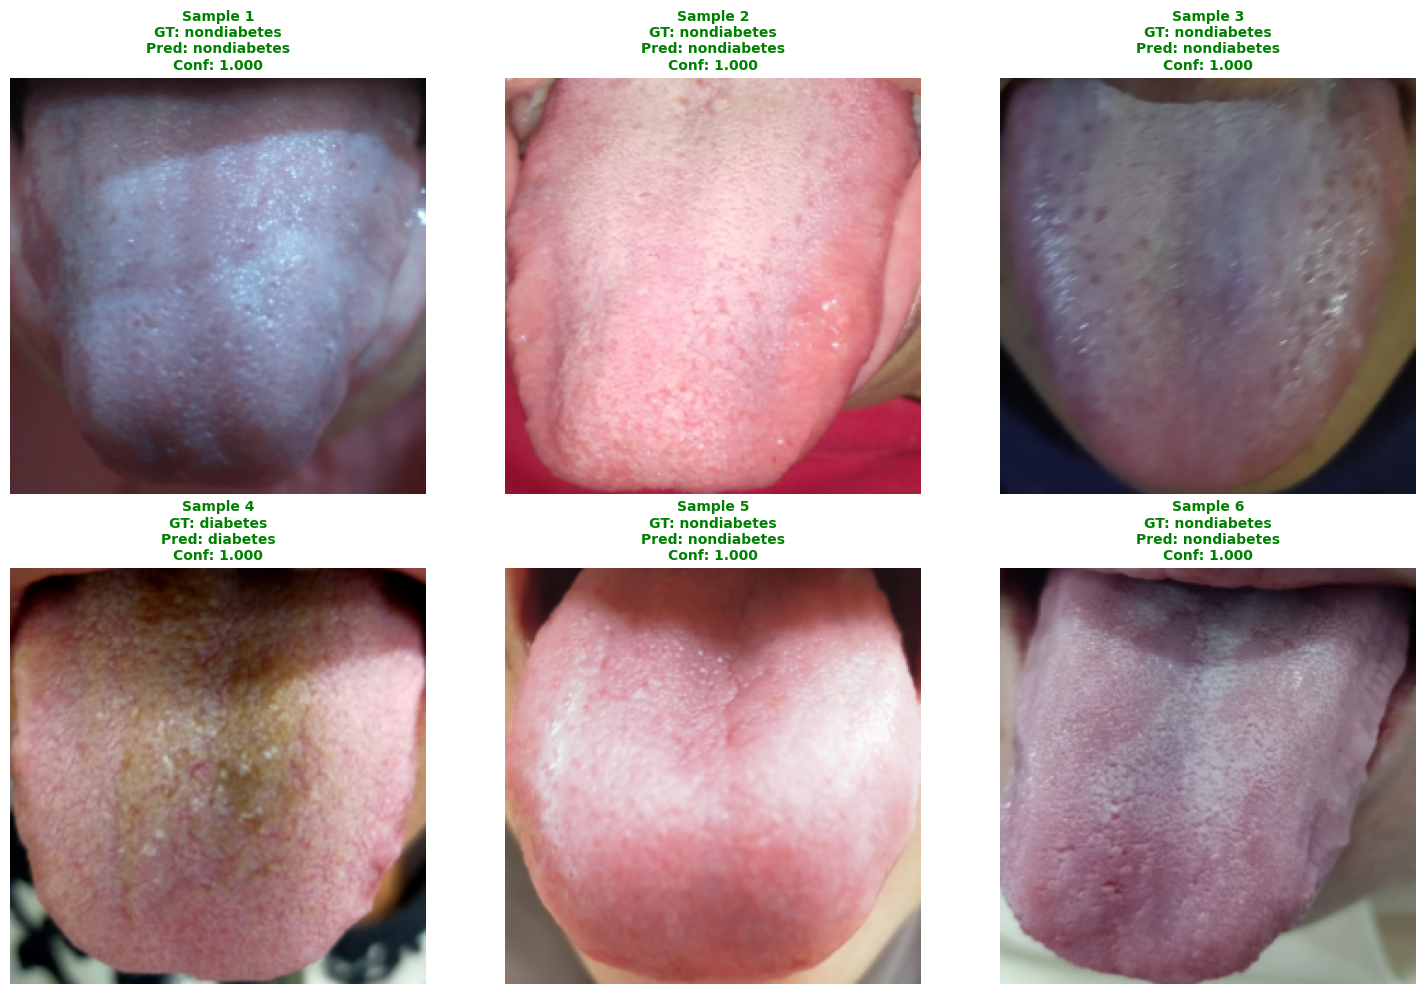


Done.


In [12]:
import os, random
import numpy as np
import torch
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt

# Config
data_dir = 'dataset'
test_dir = os.path.join(data_dir, 'test')

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

# Transforms (match notebook val_transforms)
img_size = 224
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Dataset
test_ds = datasets.ImageFolder(test_dir, transform=val_transforms)
print('Found', len(test_ds), 'test samples across classes:', test_ds.classes)
print('class_to_idx:', test_ds.class_to_idx)

# Model architecture (no pretrained weights here; we will load your checkpoint)
model = models.mobilenet_v3_small(weights=None)
# adapt classifier
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 2)
# load weights
ckpt_path = 'best_mnv3_small.pth'
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)
model.eval()

# Sampling
num_samples = 6
indices = random.sample(range(len(test_ds)), num_samples)
print('Indices:', indices)

# Helper function to denormalize image for display
def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denorm = tensor * std + mean
    return torch.clamp(denorm, 0, 1)

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img, label = test_ds[idx]
    img_path = test_ds.imgs[idx][0]
    
    # Predict
    img_batch = img.unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img_batch)  # logits
        logits = out[0].cpu().numpy()
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(logits))
        pred_class = test_ds.classes[pred_idx]

    # Display image
    img_denorm = denormalize_image(img)
    axes[i].imshow(img_denorm.permute(1, 2, 0))
    axes[i].axis('off')
    
    # Create title with prediction info
    gt_class = test_ds.classes[label]
    confidence = float(probs[pred_idx])
    title_color = 'green' if pred_class == gt_class else 'red'
    
    title = f'Sample {i+1}\nGT: {gt_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
    axes[i].set_title(title, fontsize=10, color=title_color, weight='bold')
    
    # Print detailed info
    print('-'*60)
    print(f'Sample {i+1}: idx={idx} file={os.path.basename(img_path)}')
    print('GT:', gt_class, f'(index {label})')
    print('Logits:', logits)
    print('Probs:', {test_ds.classes[0]: float(probs[0]), test_ds.classes[1]: float(probs[1])})
    print('Pred:', pred_class, f'(index {pred_idx})')

plt.tight_layout()
plt.show()

print('\nDone.')


In [13]:
import torch
from torchvision import models
from io import BytesIO
import time
import psutil
import numpy as np

# Ensure model is loaded (from your notebook)
if 'model' not in locals():
    model = models.mobilenet_v3_small(weights=None)
    model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 2)
    ckpt_path = 'best_mnv3_small.pth'
    model.load_state_dict(torch.load(ckpt_path, map_location=device, weights_only=True))
    model = model.to(device)
    model.eval()

# Device (reuse from your code)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Compute model size
buffer = BytesIO()
torch.save(model.state_dict(), buffer)
model_size_mb = buffer.tell() / (1024 * 1024)  # Convert bytes to MB
print(f"Model Size: {model_size_mb:.2f} MB")

# Compute inference time
input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Same input size as your dataset
times = []
model.eval()
with torch.no_grad():
    for _ in range(100):  # Run 100 inferences to get average
        start_time = time.time()
        _ = model(input_tensor)
        times.append((time.time() - start_time) * 1000)  # Convert to ms
avg_inference_time_ms = np.mean(times)
print(f"Average Inference Time: {avg_inference_time_ms:.2f} ms/image")

# Compute memory usage
process = psutil.Process()
mem_before = process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB
with torch.no_grad():
    _ = model(input_tensor)
mem_after = process.memory_info().rss / (1024 * 1024)
memory_usage_mb = mem_after - mem_before
print(f"Memory Usage: {memory_usage_mb:.2f} MB")

# Estimate energy consumption
power_watts = 3.0  # Typical CPU power consumption (adjust for mobile device if known)
avg_inference_time_s = avg_inference_time_ms / 1000  # Convert ms to seconds
energy_joules = power_watts * avg_inference_time_s
print(f"Estimated Energy per Inference: {energy_joules:.6f} J")

Model Size: 5.92 MB
Average Inference Time: 8.31 ms/image
Memory Usage: 0.00 MB
Estimated Energy per Inference: 0.024932 J
Average Inference Time: 8.31 ms/image
Memory Usage: 0.00 MB
Estimated Energy per Inference: 0.024932 J
